Data sourced from https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data  
Some data processing abridged from https://www.kaggle.com/code/juniorbueno/stock-market-sentimen-bert-tokenizer  
Various code snippets from COMP9444 assignment 'paraphrased'

You will need to install (via pip3): torch, matplotlib, numpy, nltk.  
You will also need to run (with python3 in terminal)  
`>>>import nltk`  
`>>>nltk.download('stopwords')`  
`>>>nltk.download('wordnet')`  
`>>>nltk.download('omw-1.4')`

In [737]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from random import shuffle

# if torch.cuda.is_available(): dev = "cuda"
# else: dev = "cpu"
dev = "cpu"
device = torch.device(dev)

with open('stock_data.csv', encoding='utf8') as csvfile:
    df = pd.read_csv(csvfile, delimiter=',')

df.dropna(axis=0, how='any', inplace=True)                         # Excludes null-containing rows
num_positive = df['Sentiment'].value_counts()[1]
num_negative = df['Sentiment'].value_counts()[-1]
print(df['Sentiment'].value_counts())

 1    3685
-1    2106
Name: Sentiment, dtype: int64


In [751]:
# Hyperparameters
word_frequency_requirement = 0.0013*(df['Sentiment'].size) # the number of times a word has to appear to be given
# it's own encoding. All words under this limit are encoded as the same 'unknown' word.
train_proportion = 0.80
hidden_layer_size = 50
learning_rate = 0.00035
batch_size = 64
epochs = 75

In [739]:
# Regex removal of various undesirable parts of a tweet
def clean_tweet(tweet):
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) # Twitter handle removal
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet) # URL removal
  tweet = re.sub(r"[']", "", tweet) # Apostrophe removal
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet) # Remove symbols that are not alphabetic or sentence endings
  tweet = re.sub(r"([^a-zA-Z])", r" \1 ", tweet) # Places spaces around sentence endings,
  # so they are encoded as their own words, rather than being lumped in with other words.
  tweet = re.sub(r" +", ' ', tweet) # Excess whitespace removal
  tweet = tweet.lower() # Send tweet to lowercase
  return tweet

In [740]:
# Prepare word lemmatizer and stopwords list for sanitisation
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))

def tokenize(tweet):
    tweet = clean_tweet(tweet)
    tweet = filter(lambda w: w not in stops, tweet.strip().split()) # Remove stopwords
    return list(map(lemmatizer.lemmatize, tweet)) # Lemmatize words.

In [741]:
san_df = pd.DataFrame([
    df['Text'].map(tokenize),
    df['Sentiment'].map(lambda x: torch.tensor([1]) if (x==1) else torch.tensor([0]))
    ]).T
    
indexes = [i for i, x in enumerate(san_df['Text']) if len(x) <= 5]
san_df.drop(indexes, inplace=True)
san_df.reset_index(drop=True, inplace=True)

print(san_df.Text[0])
san_df

['kicker', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'aj', 'trade', 'method', 'method', 'see', 'prev', 'post']


,Text,Sentiment
0,"[kicker, watchlist, xide, tit, soq, pnk, cpw, ...",[tensor(1)]
1,"[user, aap, movie, ., return, fea, geed, indic...",[tensor(1)]
2,"[user, id, afraid, short, amzn, looking, like,...",[tensor(1)]
3,"[aap, user, current, downtrend, break, ., othe...",[tensor(0)]
4,"[monday, relative, weakness, ., nyx, win, tie,...",[tensor(0)]
...,...,...
4747,"[industry, body, cii, said, discoms, likely, s...",[tensor(0)]
4748,"[gold, price, slip, r, investor, book, profit,...",[tensor(0)]
4749,"[worker, bajaj, auto, agreed, wage, cut, perio...",[tensor(1)]
4750,"[sharemarket, live, sensex, day, high, point, ...",[tensor(1)]


In [742]:
# Counter class counts number of appearances of all words
word_count = Counter()
for tweet in san_df['Text']:
    word_count.update(tweet)
        
# Create a dictionary that maps words to their one-hot vector indices
vocab = [word for word in word_count if word_count[word] >= word_frequency_requirement] # vocab contains all words meeting the word frequency requirement.

dictionary = {word : i+1 for i, word in enumerate(vocab)} # dicionary is a mapping of each vocab word to its vector index.The +1 reserves the zero index.

dictionary[None] = 0 # Index 0 is reserved to be a blanket classification for all words below the word frequency requirement.

print(word_count.most_common(10))

[('.', 6656), ('aap', 781), ('!', 687), ('user', 611), ('?', 430), ('short', 415), ('day', 375), ('stock', 363), ('today', 323), ('volume', 292)]


In [743]:
max_tweet_length = max(len(x) for x in san_df['Text'])

# Map tokenized tweets to lists of dictionary indices
encoded_df = pd.DataFrame([[list(map(lambda w : dictionary.get(w, 0), tweet)) for tweet in san_df['Text']]]).T

# Pad encoded tweets with trailing zeros
encoded_df[0] = encoded_df[0].map( lambda x: x + [0] * (max_tweet_length - len(x)) )

# Map encoded tweets to onehot vector sequences and recombine with sentiment data
onehot_df = pd.DataFrame([
    [F.one_hot(torch.LongTensor(enc_tweet), len(dictionary)) for enc_tweet in encoded_df[0]],
    san_df['Sentiment']
    ]).T

In [744]:
# Shuffle data and split into training and testing data
train_dataset = onehot_df.sample(frac = train_proportion)
test_dataset = onehot_df.drop(train_dataset.index)

train_size = train_dataset.shape[0]
test_size = test_dataset.shape[0]

train_tensor = torch.utils.data.TensorDataset(torch.stack(tuple(train_dataset[0])).type(torch.float32).to(device), torch.stack(tuple(train_dataset[1])).to(device))
test_tensor = torch.utils.data.TensorDataset(torch.stack(tuple(test_dataset[0])).type(torch.float32).to(device), torch.stack(tuple(test_dataset[1])).to(device))

train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = 1)

In [745]:
class SRN_model(nn.Module):
    def __init__(self, num_input, num_hid, num_out):
        super().__init__()
        self.num_hid = num_hid
        self.batch_size = 1
        self.H0= nn.Parameter(torch.Tensor(num_hid))
        self.W = nn.Parameter(torch.Tensor(num_input, num_hid))
        self.U = nn.Parameter(torch.Tensor(num_hid, num_hid))
        self.hid_bias = nn.Parameter(torch.Tensor(num_hid))
        self.V = nn.Parameter(torch.Tensor(num_hid, num_out))
        self.out_bias = nn.Parameter(torch.Tensor(num_out))

        # Various initialisation schemes. Initialisation is important.
        nn.init.zeros_(self.H0)
        nn.init.xavier_normal_(self.W)
        nn.init.xavier_normal_(self.U)
        nn.init.zeros_(self.hid_bias)
        nn.init.xavier_normal_(self.V)
        nn.init.zeros_(self.out_bias)

    def init_hidden(self):
        H0 = torch.tanh(self.H0)
        return(H0.unsqueeze(0))
 
    def forward(self, seq):
        seq_size, _ = seq.size()
        h_t = self.init_hidden()
        for t in range(seq_size):
            x_t = seq[t]
            c_t = x_t @ self.W + h_t @ self.U + self.hid_bias
            h_t = torch.tanh(c_t)
        output = h_t @ self.V + self.out_bias
        return output

In [746]:
def train(net, criterion, optimizer, data, label):

    loss = 0
    outputs = []

    for i in range(data.shape[0]):

        # Forward
        output = net(data[i])

        # Apply output nonlinearity. Log_softmax chosen as it is suited for classification tasks
        outputs.append(F.log_softmax(output, dim=1))
    
    loss = criterion(torch.cat(outputs, dim=0), torch.squeeze(label,1), weight=weight)
    
    loss.backward()

    optimizer.step()

    return loss.data.item()

In [747]:
net = SRN_model(len(dictionary),hidden_layer_size,2)

net.to(device)
weight = torch.FloatTensor([num_positive/num_negative, num_positive/num_positive]).to(device)

# Negative log likelihood loss. Suited for classification tasks.
criterion = F.nll_loss

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.00001)

In [748]:
plot_loss = []
plot_correct = []

num_batches = train_size//batch_size

for e in range(epochs):
    loss = 0.

    # Trains on every training data item individually each epoch
    for data, label in train_loader:
        optimizer.zero_grad()
        loss += train(net, criterion, optimizer, data, label)

    # Evaluate proportion of the test set correctly predicted.
    correct = 0
    for data, label in test_loader:
        output = net(data[0])
        if (torch.argmax(output.data) == label[0][0]): correct += 1
    accuracy = correct/test_size*100

    # Append loss and accuracy results to lists for later plotting.
    plot_loss.append(loss/num_batches)
    plot_correct.append(accuracy)
    
    # Print loss and accuracy every epoch.
    print("Epoch %02d, loss = %f, accuracy = %.2f%%" % (e+1, loss / num_batches, accuracy))

Epoch 01, loss = 0.679553, accuracy = 68.02%
Epoch 02, loss = 0.448713, accuracy = 73.49%
Epoch 03, loss = 0.213215, accuracy = 69.85%
Epoch 04, loss = 0.118650, accuracy = 70.55%
Epoch 05, loss = 0.069366, accuracy = 71.39%
Epoch 06, loss = 0.047285, accuracy = 69.57%
Epoch 07, loss = 0.033271, accuracy = 70.27%
Epoch 08, loss = 0.029940, accuracy = 73.35%
Epoch 09, loss = 0.031362, accuracy = 70.69%
Epoch 10, loss = 0.023567, accuracy = 72.51%
Epoch 11, loss = 0.035335, accuracy = 69.71%
Epoch 12, loss = 0.025123, accuracy = 69.14%
Epoch 13, loss = 0.018129, accuracy = 68.44%
Epoch 14, loss = 0.013700, accuracy = 70.69%
Epoch 15, loss = 0.013216, accuracy = 69.85%
Epoch 16, loss = 0.025220, accuracy = 68.16%
Epoch 17, loss = 0.025090, accuracy = 70.41%
Epoch 18, loss = 0.014321, accuracy = 69.42%
Epoch 19, loss = 0.022856, accuracy = 72.51%
Epoch 20, loss = 0.018852, accuracy = 69.42%
Epoch 21, loss = 0.009130, accuracy = 70.69%
Epoch 22, loss = 0.008888, accuracy = 70.69%
Epoch 23, 

KeyboardInterrupt: 

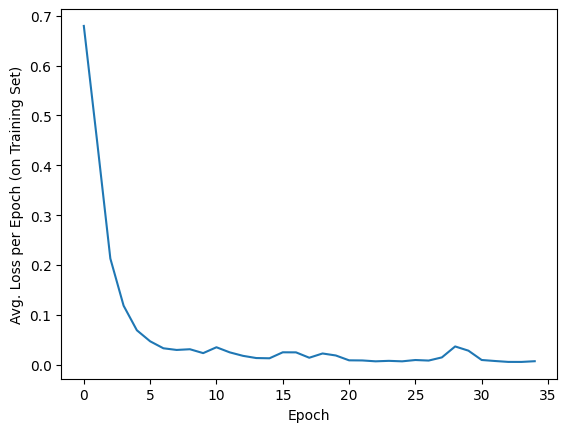

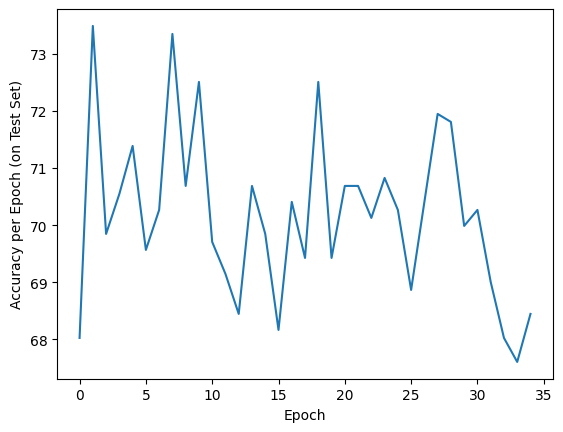

In [752]:
# Plot results
plt.plot(plot_loss)
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss per Epoch (on Training Set)')
plt.show()

plt.plot(plot_correct)
plt.xlabel('Epoch')
plt.ylabel('Accuracy per Epoch (on Test Set)')
plt.show()

In [ ]:
tweet = input("Input a financial tweet to analyse: ") # Upswings on my watchlist: AAPL, SPX, AMZN. Don't forget to hold DIAMOND HANDS
tok_tweet = tokenize(tweet)
enc_tweet = list(map(lambda w : dictionary.get(w, 0), tok_tweet))
data = F.one_hot(torch.LongTensor(enc_tweet), len(dictionary)).to(device)

output = net(data.type(torch.float32))
log_prob = F.log_softmax(output, dim=1)
prob_out = torch.exp(log_prob).data[0]

print("Positive with probability", round(prob_out[1].item(), 2), "%, Negative with probability", round(prob_out[0].item(), 2), "%")

Positive with probability 0.09 %, Negative with probability 0.91 %
